Multiplexed sequencing
======================

The Pulsar QRM/QCM supports six sequencers. The output of each sequencer is multiplexed, accumulated and connected to the output ports of the instrument as shown in the figure below. Furthermore, input paths 0 and 1 of every sequencer are connected to inputs $\text{I}^{1}$ and $\text{I}^{2}$ respectively. In the first part of the tutorial we will connect outputs of multiple sequencers to a single pair of output ports and demonstrate how to multiplex output paths 0 and 1 of these sequencers as well as show how these multiplexed signals are accumulated. In the second part of the tutorial we will demonstrate firstly, how to frequency multiplex the output paths of different sequencers at different unique carrier frequencies on a single pair of output ports and secondly, how to aquire, demodulated and integrate the recieved frequency multiplexed waveforms. In the third part of the tutorial we will demonstrate "real mode", where we will control various sequencers to independantly output real signals on each output port of the instrument.

We will show this by using a Pulsar QRM and directly connecting outputs 
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the Pulsar QRM's sequencers to sequence waveforms on 
the outputs and simultaneously acquire the resulting waveforms on the inputs.

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
#Set up the environment.
import scipy.signal
import math
import json
import matplotlib.pyplot
import numpy
import time
from scipy.fft import rfft, rfftfreq

from qblox_instruments import Pulsar

#Close any existing connections to any Pulsar.
Pulsar.close_all()

#Connect to the Pulsar at default IP address.
pulsar = Pulsar("pulsar", "192.168.0.2")

#Reset the instrument for good measure.
pulsar.reset()
print("Status:")
print(pulsar.get_system_state())

Status:
SystemState(status=<SystemStatus.OKAY: 2>, flags=[])


Generate waveforms
-----------------

Next, we need to create the waveforms for the sequence.

In [2]:
#Waveforms
waveform_len = 1000
waveforms    = {
                    "gaussian": {"data": scipy.signal.gaussian(waveform_len, std=0.133*waveform_len).tolist(),   "index": 0},
                    "sine":     {"data": [math.sin((2*math.pi/waveform_len)*i) for i in range(0, waveform_len)], "index": 1},
                    "sawtooth": {"data": [(1.0/waveform_len)*i for i in range(0, waveform_len)],                 "index": 2},
                    "block":    {"data": [1.0 for i in range(0, waveform_len)],                                  "index": 3}
               }

Let's plot the waveforms to see what we have created.

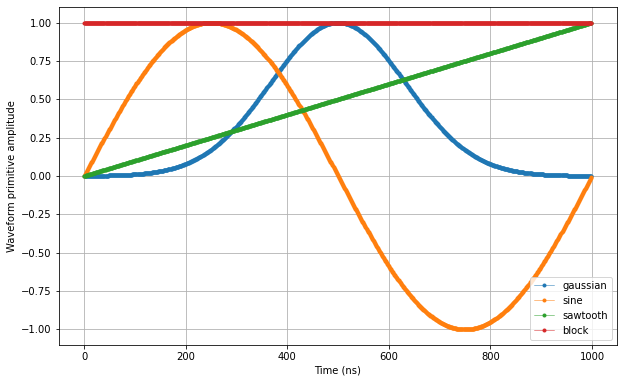

In [3]:
time    = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(10, 10/1.61))

for wf, d in waveforms.items():
    ax.plot(time[:len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Specify the acquisitions
--------------------

We will only use a single bin in this tutorial, so we can keep it simple

In [4]:
#Acquisitions
acquisitions = {"scope": {"num_bins": 1,"index": 0}}

Create Q1ASM program and upload the sequence
--------------------

Now that we have the waveform and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms and triggers the acquisitions. In this case we will play a gaussian and a sinosoid wave for path 0 and 1 respectively per sequencer.

In [5]:
#Number of sequencers per instrument
num_seq = 6

#Program
program = """
wait_sync 4
play      0,1,4
wait      140
acquire   0,0,16380
stop
"""

#Write sequence to file.
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump({"waveforms": waveforms, "weights": waveforms, "acquisitions": acquisitions, "program": program}, file, indent=4)
    file.close()

#Program sequencers.
for sequencer in pulsar.sequencers:
    sequencer.sequence("sequence.json")

Multiplexed sequencer output control
------------------------------------
The output paths of each sequencer are connected to the instrument's outputs as shown in the figure below. Path 0 of each sequencer can be connected to output $\text{O}^{1}$ and $\text{O}^{3}$ and path 1 to $\text{O}^{2}$ and $\text{O}^{4}$ respectively in case of a Pulsar QCM, while path 0 can only be connected to output $\text{O}^{1}$ and path 1 to output $\text{O}^{2}$ respectively in case of a Pulsar QRM. In order to connect the sequencer output paths to corresponding output ports, we need to configure the sequencer's channel map by calling sequencer`X`_channel_map_path`Y`_out`Z`_en where `X`, `Y` and `Z` represents sequencer ID, path ID and output port number respectively.

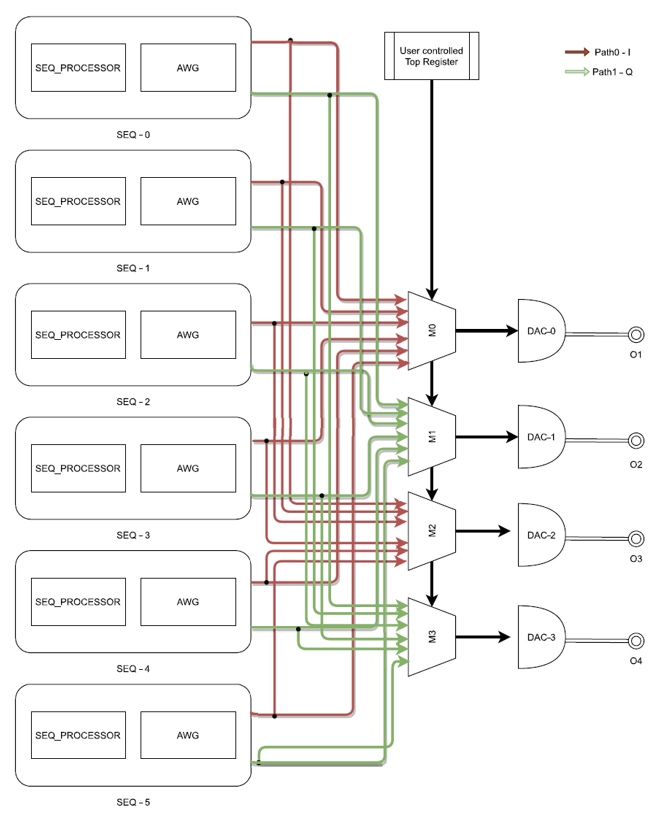

Now lets configure the first sequencer to output its paths on $\text{O}^{1}$ and $\text{O}^{2}$. We will scale the amplitude of the signal such that we are able the show what happens when other sequencers are added and eventually output overflow occurs.

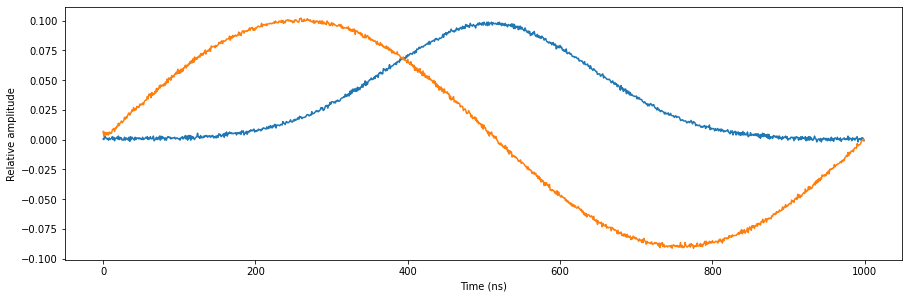

In [6]:
#Configure the sequencer to trigger the scope acquisition.
pulsar.scope_acq_sequencer_select(0)
pulsar.scope_acq_trigger_mode_path0("sequencer")
pulsar.scope_acq_trigger_mode_path1("sequencer")

#Configure sequencer
pulsar.sequencer0.sync_en(True)
pulsar.sequencer0.gain_awg_path0(1.1/num_seq) #The output range is 1.0 to -1.0, but we want to show what happens when the signals go out of range.
pulsar.sequencer0.gain_awg_path1(1.1/num_seq)
pulsar.sequencer0.channel_map_path0_out0_en(True)
pulsar.sequencer0.channel_map_path1_out1_en(True)

#Start the sequence
pulsar.arm_sequencer(0)
pulsar.start_sequencer()

#Wait for the sequencer to stop
pulsar.get_acquisition_state(0, 1)

#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

#Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')    

matplotlib.pyplot.show()

Let's add the second sequencer.

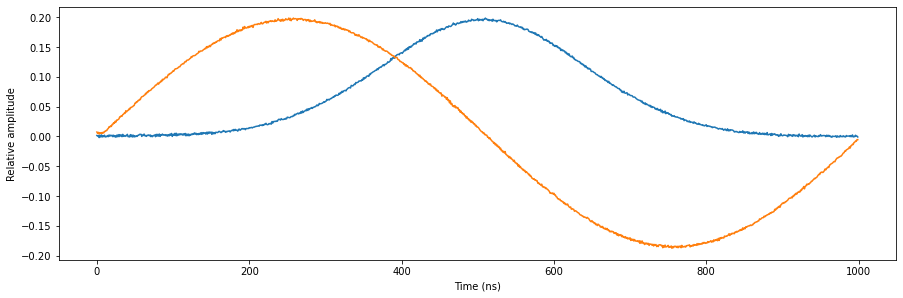

In [7]:
#Configure the sequencer
pulsar.sequencer1.sync_en(True)
pulsar.sequencer1.gain_awg_path0(1.1/num_seq)
pulsar.sequencer1.gain_awg_path1(1.1/num_seq)
pulsar.sequencer1.channel_map_path0_out0_en(True)
pulsar.sequencer1.channel_map_path1_out1_en(True)

#Start the sequencers
for seq in range(0, 2):
    pulsar.arm_sequencer(seq)
pulsar.start_sequencer()

#Wait for sequencers to stop
for seq in range(0, 2):
    pulsar.get_acquisition_state(seq, 1)

#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

#Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')    

matplotlib.pyplot.show()

Let's add the third sequencer.

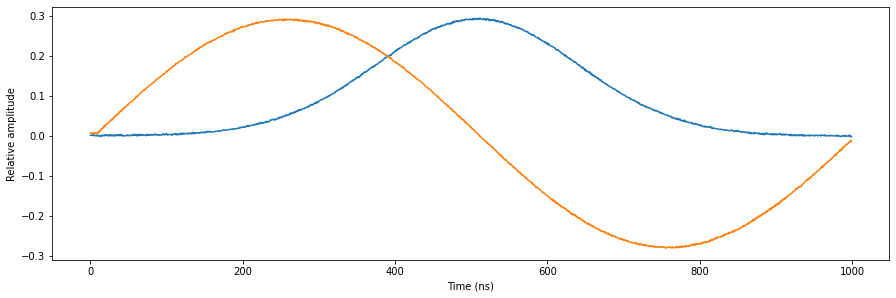

In [8]:
#Configure the sequencer
pulsar.sequencer2.sync_en(True)
pulsar.sequencer2.gain_awg_path0(1.1/num_seq)
pulsar.sequencer2.gain_awg_path1(1.1/num_seq)
pulsar.sequencer2.channel_map_path0_out0_en(True)
pulsar.sequencer2.channel_map_path1_out1_en(True)

#Start the sequencers
for seq in range(0, 3):
    pulsar.arm_sequencer(seq)
pulsar.start_sequencer()

#Wait for sequencers to stop
for seq in range(0, 3):
    pulsar.get_acquisition_state(seq, 1)

#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

#Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')    

matplotlib.pyplot.show()

Let's add the fourth sequencer.

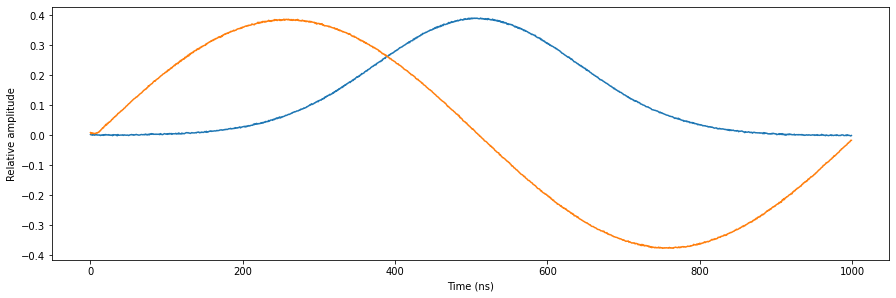

In [9]:
#Configure the sequencer
pulsar.sequencer3.sync_en(True)
pulsar.sequencer3.gain_awg_path0(1.1/num_seq)
pulsar.sequencer3.gain_awg_path1(1.1/num_seq)
pulsar.sequencer3.channel_map_path0_out0_en(True)
pulsar.sequencer3.channel_map_path1_out1_en(True)

#Start the sequencers
for seq in range(0, 4):
    pulsar.arm_sequencer(seq)
pulsar.start_sequencer()

#Wait for sequencers to stop
for seq in range(0, 4):
    pulsar.get_acquisition_state(seq, 1)

#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

#Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')    

matplotlib.pyplot.show()

Let's add the fifth sequencer.

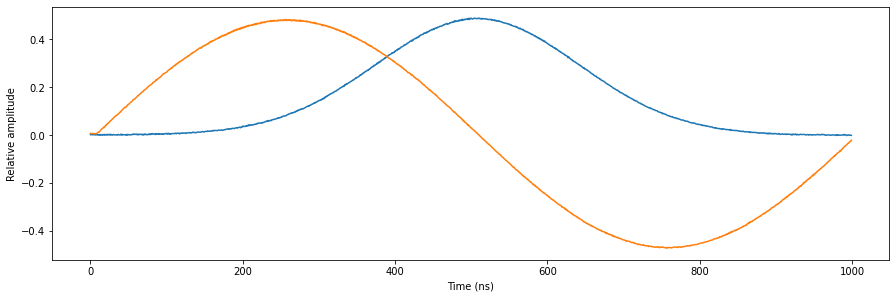

In [10]:
#Configure the sequencer
pulsar.sequencer4.sync_en(True)
pulsar.sequencer4.gain_awg_path0(1.1/num_seq)
pulsar.sequencer4.gain_awg_path1(1.1/num_seq)
pulsar.sequencer4.channel_map_path0_out0_en(True)
pulsar.sequencer4.channel_map_path1_out1_en(True)

#Start the sequencers
for seq in range(0, 5):
    pulsar.arm_sequencer(seq)
pulsar.start_sequencer()

#Wait for sequencers to stop
for seq in range(0, 5):
    pulsar.get_acquisition_state(seq, 1)

#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

#Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')    

matplotlib.pyplot.show()

Let's add the sixth sequencer.

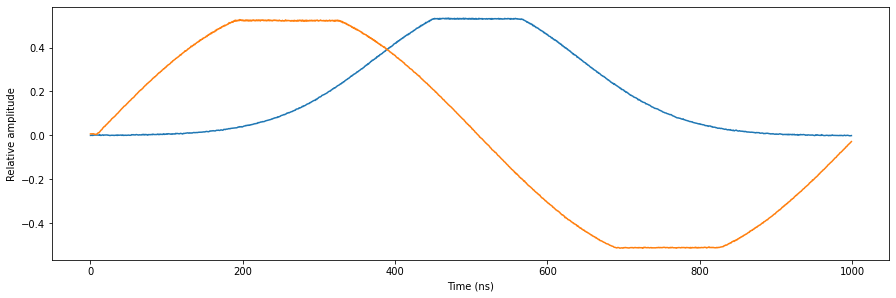

In [11]:
#Configure the sequencer
pulsar.sequencer5.sync_en(True)
pulsar.sequencer5.gain_awg_path0(1.1/num_seq)
pulsar.sequencer5.gain_awg_path1(1.1/num_seq)
pulsar.sequencer5.channel_map_path0_out0_en(True)
pulsar.sequencer5.channel_map_path1_out1_en(True)

#Start the sequencers
for seq in range(0, 6):
    pulsar.arm_sequencer(seq)
pulsar.start_sequencer()

#Wait for sequencers to stop
for seq in range(0, 6):
    pulsar.get_acquisition_state(seq, 1)

#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

#Plot the results
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')    

matplotlib.pyplot.show()

Note that now the outputs overflow and the output signal is clipped as intended. Also note that the output range of a Pulsar QRM is 1 Vpp, while it's input range is 2 Vpp. This causes the signal in the figure to be clipped at 0.5 and -0.5.

Frequency multiplexing
----------------------
Next, we will show frequency multiplexing. We will connect the outputs of various sequencers to a single output port pair, modulate their waveforms on unique carrier frequencies and in turn acquire, demodulate and integrate the results fed back into the inputs to validate the acquired signals. In this case, for simplicity, we will modulate a square wave pulse on each sequencer and we will play with the output gain. In order to visualise the frequency multiplexing, we will preform an FFT over the acquired scope acquisitions.

In [12]:
#Reset
pulsar.reset()

#Program
program = """
      wait_sync 4
loop: play      3,3,4
      wait      140
      acquire   0,0,16380
      stop
"""

#Write sequence to file
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump({"waveforms": waveforms, "weights": waveforms, "acquisitions": acquisitions, "program": program}, file, indent=4)
    file.close()

Lets start with a single sequencer with an AWG gain of 1.0 (only on path 0 to create a "real" pulse). Let's modulate it's output with a carrier frequency of 20MHz.

In [13]:
#Program sequencer
pulsar.sequencer0.sequence("sequence.json")

#Configure the channel map
pulsar.sequencer0.channel_map_path0_out0_en(True)
pulsar.sequencer0.channel_map_path1_out1_en(True)

#Configure sequencer
pulsar.sequencer0.sync_en(               True)
pulsar.sequencer0.gain_awg_path0(        1.0)
pulsar.sequencer0.gain_awg_path1(        0.0)
pulsar.sequencer0.nco_freq(              20e6)
pulsar.sequencer0.mod_en_awg(            True)
pulsar.sequencer0.demod_en_acq(          True)
pulsar.sequencer0.integration_length_acq(waveform_len)

In [14]:
#Start the sequencer
pulsar.arm_sequencer(0)
pulsar.start_sequencer(0)

#Wait for the sequencer to stop
pulsar.get_acquisition_state(0, 1)

#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of one tone at 20MHz.

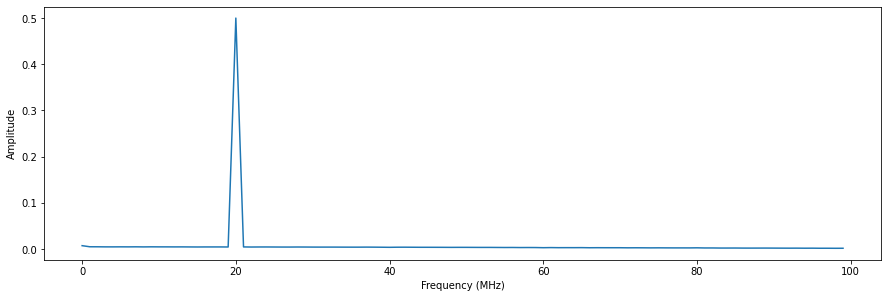

In [15]:
#Plot the FFT
fig, bx = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1/1e3)
norm_fact = pulsar.sequencer0.gain_awg_path0() / 2 / numpy.max(yf)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel('Frequency (MHz)')
bx.set_ylabel('Amplitude')
matplotlib.pyplot.show() 

Now let's have a look at the hardware demodulated and integrated results and check if it matches our expectations. Don't forget that we need to divide the integration results by the integration length. In this case, the integration length is the same as the waveform length.

In [16]:
bins = acq["scope"]["acquisition"]["bins"]
I = bins["integration"]["path0"][0] / waveform_len
Q = bins["integration"]["path1"][0] / waveform_len
print("Integeration results:")
print("I = {}".format(I))
print("Q = {}".format(Q))
print("R = sqrt(I^2 + Q^2) = {}".format(math.sqrt(I**2 + Q**2)))

Integeration results:
I = -0.25398241328773813
Q = -0.4319819247679531
R = sqrt(I^2 + Q^2) = 0.501114208125941


The pulse acquired at the inputs is automatically demodulated at 20MHz, but due to phase rotation caused by output-to-input latency the result is not purely real. However the amplitude of the IQ vector is 0.5 as expected because: 1Vpp output range / 2Vpp input range = 0.5.

Now lets increase the number of sequencers to three, each with a slightly different AWG gain. We will modulate the signals of sequencer 0 to 2 with a carrier frequencies at 20MHz, 30MHz and 40MHz respectively.

In [17]:
num_seq = 3
for seq in range(0, num_seq):
    #Program sequencers
    pulsar.sequencers[seq].sequence("sequence.json")
    
    #Configure the channel map
    pulsar.sequencers[seq].channel_map_path0_out0_en(True)
    pulsar.sequencers[seq].channel_map_path1_out1_en(True)
    
    #Configure the sequencers
    pulsar.sequencers[seq].sync_en(True)
    pulsar.sequencers[seq].mod_en_awg(True)
    pulsar.sequencers[seq].demod_en_acq(True)
    pulsar.sequencers[seq].integration_length_acq(waveform_len)

#Set the gains
pulsar.sequencer0.gain_awg_path0(0.5)
pulsar.sequencer0.gain_awg_path1(0.0)
pulsar.sequencer1.gain_awg_path0(0.25)
pulsar.sequencer1.gain_awg_path1(0.0)
pulsar.sequencer2.gain_awg_path0(0.125)
pulsar.sequencer2.gain_awg_path1(0.0)
   
#Set the frequencies
pulsar.sequencer0.nco_freq(20e6)
pulsar.sequencer1.nco_freq(30e6)
pulsar.sequencer2.nco_freq(40e6)

In [18]:
#Start the sequencers
for seq in range(0, 3):
    pulsar.arm_sequencer(seq)
pulsar.start_sequencer()

#Wait for sequencers to stop
for seq in range(0, 3):
    pulsar.get_acquisition_state(seq, 1)
    
#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of three tones at 20MHz, 30Mhz and 40MHz.

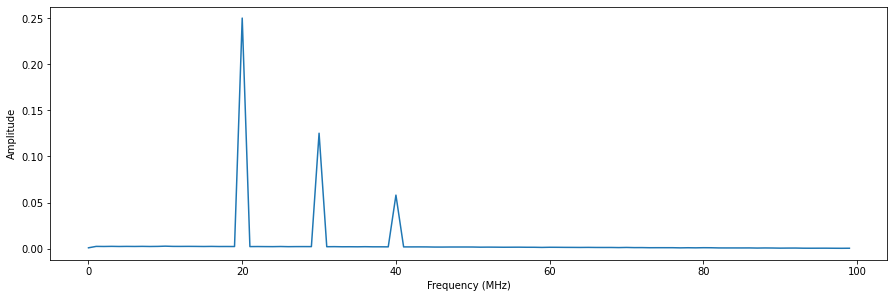

In [19]:
#Plot the FFT
fig, bx = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1/1e3)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel('Frequency (MHz)')
bx.set_ylabel('Amplitude')
matplotlib.pyplot.show() 

Now let's check if the hardware demodulated and integrated results match our expectations.

In [20]:
for seq in range(0, num_seq):
    pulsar.store_scope_acquisition(seq, "scope")
    acq = pulsar.get_acquisitions(seq)
    bins = acq["scope"]["acquisition"]["bins"]
    I = bins["integration"]["path0"][0] / waveform_len
    Q = bins["integration"]["path1"][0] / waveform_len
    print("Sequencer {}".format(seq))
    print("Integeration results:")
    print("I = {}".format(I))
    print("Q = {}".format(Q))
    print("R = sqrt(I^2 + Q^2) = {}".format(math.sqrt(I**2 + Q**2)))
    print('---------------------------------------------------------------------------------')

Sequencer 0
Integeration results:
I = -0.12558329262335124
Q = -0.21998876404494383
R = sqrt(I^2 + Q^2) = 0.25331052029504075
---------------------------------------------------------------------------------
Sequencer 1
Integeration results:
I = -0.12424963361016121
Q = 0.005027357107962873
R = sqrt(I^2 + Q^2) = 0.12435129983940774
---------------------------------------------------------------------------------
Sequencer 2
Integeration results:
I = -0.028065950170981926
Q = 0.05475476306790425
R = sqrt(I^2 + Q^2) = 0.06152870580162052
---------------------------------------------------------------------------------


Again, the acquired signals on the input are automatically demodulated at 20MHz, 30MHz and 40MHz and we see that the amplitude of the IQ vectors match the gain values we set divided by two, which matches our expectations.

Now, let's try it one final time with six sequencers, each with 0.15 AWG gain. We will modulate the outputs of sequencer 0 to 5 with carrier frequencies at 20MHz, 30Mhz, 40MHz, 50MHz, 60MHz and 70MHz respectivey.

In [21]:
num_seq = 6
for seq in range(0, num_seq):
    #Program sequencers
    pulsar.sequencers[seq].sequence("sequence.json")
    
    #Configure the channel map
    pulsar.sequencers[seq].channel_map_path0_out0_en(True)
    pulsar.sequencers[seq].channel_map_path1_out1_en(True)
    
    #Configure the sequencers
    pulsar.sequencers[seq].sync_en(True)
    pulsar.sequencers[seq].gain_awg_path0(0.15)
    pulsar.sequencers[seq].gain_awg_path1(0.0)
    pulsar.sequencers[seq].mod_en_awg(True)
    pulsar.sequencers[seq].demod_en_acq(True)
    pulsar.sequencers[seq].integration_length_acq(waveform_len)
   
#Set the frequencies
pulsar.sequencer0.nco_freq(20e6)
pulsar.sequencer1.nco_freq(30e6)
pulsar.sequencer2.nco_freq(40e6)
pulsar.sequencer3.nco_freq(50e6)
pulsar.sequencer4.nco_freq(60e6)
pulsar.sequencer5.nco_freq(70e6)

In [22]:
#Start the sequencers
for seq in range(0, 6):
    pulsar.arm_sequencer(seq)
pulsar.start_sequencer()

#Wait for sequencers to stop
for seq in range(0, 6):
    pulsar.get_acquisition_state(seq, 1)
    
#Get acquisition data
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of six tones at 20MHz, 30Mhz, 40MHz, 50MHz, 60MHz and 70MHz

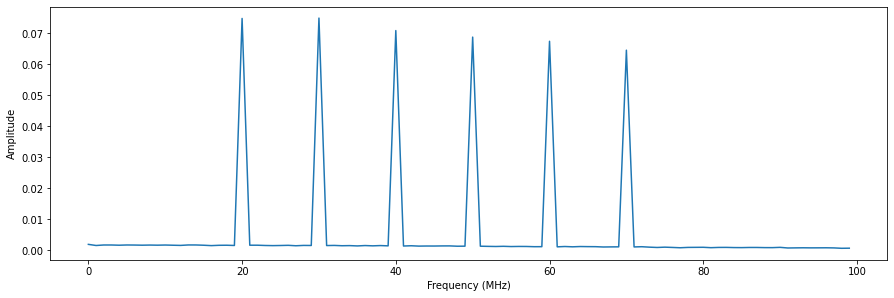

In [23]:
#Plot the FFT
fig, bx = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1/1e3)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel('Frequency (MHz)')
bx.set_ylabel('Amplitude')
matplotlib.pyplot.show() 

Note that we lose a little bit of power over the frequency range, but that is to be expected due to frequency dependant components in the output and input path. Now let's check if the hardware demodulated and integrated results match our expectations.

In [24]:
for seq in range(0, num_seq):
    pulsar.store_scope_acquisition(seq, "scope")
    acq = pulsar.get_acquisitions(seq)
    bins = acq["scope"]["acquisition"]["bins"]
    I = bins["integration"]["path0"][0] / waveform_len
    Q = bins["integration"]["path1"][0] / waveform_len
    print("Sequencer {}".format(seq))
    print("Integeration results:")
    print("I = {}".format(I))
    print("Q = {}".format(Q))
    print("R = sqrt(I^2 + Q^2) = {}".format(math.sqrt(I**2 + Q**2)))
    print('---------------------------------------------------------------------------------')

Sequencer 0
Integeration results:
I = -0.037033219345383485
Q = -0.06565461651196874
R = sqrt(I^2 + Q^2) = 0.07537896261170596
---------------------------------------------------------------------------------
Sequencer 1
Integeration results:
I = -0.07283976551050317
Q = -0.0013903273082559843
R = sqrt(I^2 + Q^2) = 0.07285303322202288
---------------------------------------------------------------------------------
Sequencer 2
Integeration results:
I = -0.03371275036638984
Q = 0.06492330239374695
R = sqrt(I^2 + Q^2) = 0.07315452638747945
---------------------------------------------------------------------------------
Sequencer 3
Integeration results:
I = 0.03564728871519297
Q = 0.05830581338544211
R = sqrt(I^2 + Q^2) = 0.06833957175226023
---------------------------------------------------------------------------------
Sequencer 4
Integeration results:
I = 0.06905324865657059
Q = 0.004781631656082071
R = sqrt(I^2 + Q^2) = 0.06921860408387773
-------------------------------------------

Taking the power loss over frequency into account, the amplitudes of the IQ vectors match our expectations again.

Real mode
---------------

Many applications require multiple outputs to be controlled independantly and only output real signals instead of a modulated IQ pair. To achieve this we will connect one sequencer to each output and only use path 0 to control an even numbered output and path 1 to control an odd numbered output. To demonstrate this, we will simply output an independantly timed sine on output $\text{O}^{1}$ and a sawtooth on output $\text{O}^{2}$, which we will then acquire on the inputs.

Lets create a Q1ASM program to sequence the waveforms for sequencer 0.

In [25]:
#Reset
pulsar.reset()

#Program
program = """
wait_sync 4
play      1,1,4
wait      140
acquire   0,0,16380
stop
"""

#Write sequence to file
with open("sequence0.json", 'w', encoding='utf-8') as file:
    json.dump({"waveforms": waveforms, "weights": waveforms, "acquisitions": acquisitions, "program": program}, file, indent=4)
    file.close()

Lets create a Q1ASM program to sequence the waveforms for sequencer 1.

In [26]:
#Program
program = """
wait_sync 4
wait      500
play      2,2,1000
stop
"""

#Write sequence to file
with open("sequence1.json", 'w', encoding='utf-8') as file:
    json.dump({"waveforms": waveforms, "weights": waveforms, "acquisitions": acquisitions, "program": program}, file, indent=4)
    file.close()

Let's configure both sequencers and connect them to their respective outputs.

In [27]:
#Configure scope mode
pulsar.scope_acq_sequencer_select(0)
pulsar.scope_acq_trigger_mode_path0("sequencer")
pulsar.scope_acq_trigger_mode_path1("sequencer")

#Program sequencer
num_seq = 2
for seq in range(0, num_seq):
    pulsar.sequencers[seq].sequence("sequence{}.json".format(seq))

#Configure the channel map
pulsar.sequencer0.channel_map_path0_out0_en(True)
pulsar.sequencer1.channel_map_path1_out1_en(True)

#Configure sequencer
for seq in range(0, num_seq):
    pulsar.sequencers[seq].sync_en(True)
    pulsar.sequencers[seq].mod_en_awg(False)
    
pulsar.sequencer0.gain_awg_path1(0.0) #Disable sequencer 0 path 1, because we will not use it.
pulsar.sequencer1.gain_awg_path0(0.0) #Disable sequencer 1 path 0, because we will not use it.

Now, let start the sequencers and visualise the resulting sequence.

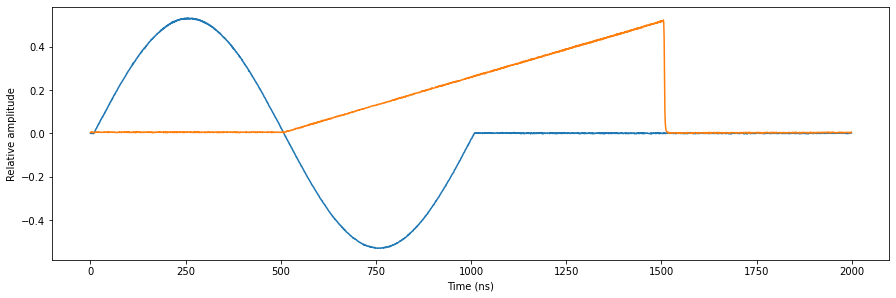

In [28]:
#Start sequencers
for seq in range(0, num_seq):
    pulsar.arm_sequencer(seq)
pulsar.start_sequencer()

#Wait for sequencers to stop (only sequencer 0 will acquire)
for seq in range(0, num_seq):
    pulsar.get_sequencer_state(seq, 1)
pulsar.get_acquisition_state(0, 1)

#Get acquisition
pulsar.store_scope_acquisition(0, "scope")
acq = pulsar.get_acquisitions(0)

#Plot result
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:2000])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:2000])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')    
matplotlib.pyplot.show()

As expected, we see a sine and sawtooth that are independantly sequenced on the outputs.

Stop
----

In [29]:
#Print an overview of the instrument parameters.
print("Snapshot:")
pulsar.print_readable_snapshot(update=True)
    
#Close the instrument connection.
pulsar.close()

Snapshot:
pulsar:
	parameter                    value
--------------------------------------------------------------------------------
IDN                           :	{'manufacturer': 'qblox', 'model': 'pulsar_qr...
in0_gain                      :	-6 (dB)
in1_gain                      :	-6 (dB)
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
reference_source              :	internal 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 
pulsar_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
channel_map_path0_out0_en        :	True 
channel_map_path1_out1_en        :	True 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_wa